# Python Practice Lecture 14 MATH 342W Queens College - Linear Models with Feature Interactions
## Author: Amir ElTabakh
## Date: March 17, 2021

## Agenda:
* Orthonormal vs raw polynomials
* Log transformations
* Linear Models with Feature Interactions

## Orthonormal vs raw polynomials

Why is orthonormal polynomial the default? You can argue that doing a `QR` decomposition on the polynomial expansion and employing `Q` in the design matrix will change `b` thereby making `b` uninterpretable! So why use orthonormal polynomials?

In [1]:
# importing dependencies
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error # calculates RMSE
import pandas as pd

# Data viz
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette("colorblind")) # setting color palette
sns.set(rc={"figure.figsize":(10, 6)}) #width=8, #height=5

In [2]:
# Set seed
#np.random.seed(6048)

n = 1000
X = pd.DataFrame([[np.random.uniform(low = 0, high = 0.01)] for i in range(n//2)])
X = X.append(pd.DataFrame([[np.random.uniform(low = 0, high = 1000000)] for i in range(n//2)]), ignore_index = True)
X

,0
0,0.004224
1,0.008173
2,0.000218
3,0.009233
4,0.001475
...,...
995,914503.807281
996,593445.061369
997,688669.302002
998,739409.233461


So we have our $\vec{x}$, now we can get the polynomial expansion of $\vec{x}$ to an arbitrary degree. There is no function that I know of to do this, so I'll write my own here (I should start contributing these functions to open source libraries).

Afterward's we'll calculate the orthonomal projection of  $\vec{x}$. 

In [3]:
def poly_feats(input_values, degree):
    if degree==1:
        if 1 not in input_values:
            result = input_values
        result=input_values
        return result
    elif degree > 1:
        new_result=[]
        result = poly_feats(input_values, degree-1)
        new_result.extend(result)
        for item in input_values:
            for p_item in result:
                res=item*p_item
                if (res not in result) and (res not in new_result):
                    new_result.append(res)
        return new_result


def get_poly_feats(df, degree):
    result = {}
    for index, row in df.iterrows():
        result[index] = poly_feats(row.tolist(), degree)

    return pd.DataFrame(result).transpose()

In [4]:
# create model matrix
X_mm = get_poly_feats(X, 8)

# ouput snapshot
num_digits = 8
round(X_mm, num_digits)

,0,1,2,3,4,5,6,7
0,0.004224,1.784000e-05,8.000000e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.008173,6.680000e-05,5.500000e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,0.000218,5.000000e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,0.009233,8.524000e-05,7.900000e-07,1.000000e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,0.001475,2.170000e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
995,914503.807281,8.363172e+11,7.648153e+17,6.994265e+23,6.396282e+29,5.849424e+35,5.349321e+41,4.891974e+47
996,593445.061369,3.521770e+11,2.089977e+17,1.240287e+23,7.360420e+28,4.368005e+34,2.592171e+40,1.538311e+46
997,688669.302002,4.742654e+11,3.266120e+17,2.249277e+23,1.549008e+29,1.066754e+35,7.346408e+40,5.059246e+46
998,739409.233461,5.467260e+11,4.042543e+17,2.989093e+23,2.210163e+29,1.634215e+35,1.208354e+41,8.934679e+46


You get numerical underflow almost immediately when using the raw polynomial computations (you get it by degree 4). And thus you can't even get the OLS estimates as we see below.

In [5]:
# define y
y = [[np.random.normal(0, 1)] for i in range(n)]

# solve for b vector
b_X_mm = np.linalg.inv(X_mm.transpose() @ X_mm) @ X_mm.transpose() @ y
b_X_mm

,0
0,1.614668e-05
1,-2.552551e-10
2,1.595186e-15
3,-5.186725e-21
4,9.670371e-27
5,-1.048209e-32
6,6.161138e-39
7,-1.519335e-45


You get numerical overflow in the design matrix. Python can handle the computations if you try to use the design matrix with 10^46's to calculate the weights.

In [6]:
X_mm_slice = X_mm.iloc[800:1000, :]
np.linalg.inv(X_mm_slice.transpose() @ X_mm_slice) @ X_mm_slice.transpose() @ y[800:1000]

,0
0,1.232807e-05
1,-2.109999e-10
2,1.247541e-15
3,-3.528574e-21
4,5.366377e-27
5,-4.480281e-33
6,1.919701e-39
7,-3.263578e-46


Orthonormal vectors are a special instance of orthogonal ones. In addition to having a  angle between them, orthonormal vectors each have a magnitude of 1. In particular, the following three conditions must be met:

* $u \cdot v = 0$
* $||u|| = 1$
* $||v|| = 1$

That's just review. There's an easy way to calculate these orthonormal basis vectors and we've done it already, QR decomposition gives us an orthonormal projection matrix, as Q.T, and Q is itself the matrix of orthonormal basis vectors.

In [7]:
Q, R = np.linalg.qr(X)
Q = pd.DataFrame(Q)

# Convert to polynomial expansion (1000 x 8)
Q_mm = get_poly_feats(Q, 8)

# output b vec
b_Q_mm = np.linalg.inv(Q_mm.transpose() @ Q_mm) @ Q_mm.transpose() @ y
b_Q_mm

,0
0,-2.104787e+02
1,-4.337342e+04
2,-3.533337e+06
3,-1.497584e+08
4,-3.639697e+09
5,-5.142735e+10
6,-3.940317e+11
7,-1.266624e+12


In [8]:
# let's output b_X_mm to compare
b_X_mm

,0
0,1.614668e-05
1,-2.552551e-10
2,1.595186e-15
3,-5.186725e-21
4,9.670371e-27
5,-1.048209e-32
6,6.161138e-39
7,-1.519335e-45


In [9]:
X_mm_slice = X_mm
np.linalg.inv(X_mm_slice.transpose() @ X_mm_slice) @ X_mm_slice.transpose() @ y

,0
0,1.614668e-05
1,-2.552551e-10
2,1.595186e-15
3,-5.186725e-21
4,9.670371e-27
5,-1.048209e-32
6,6.161138e-39
7,-1.519335e-45


No problem at all! So we've shown that one could extract the weights for the polynomial expansion of $\vec{x}$ to any degree, and did the same via the orthonormal projection of $\vec{x}$ to any degree, the Q matrix.

If you need interpretability, you need raw polynomials, not the orthonormal Q. But if you're interpreting the model, how do you even interpret beyond degree 2?

# Log Transformations

We will be examining the diamonds dataset. Let's take a moment to read about our data. In real life, you will take more than just a moment to learn about the data, and more than just a moment to clean the data and do sanity checks. As these steps are more of the grunt work of data science (and are learned on the fly), it won't really cover them formally.



In [10]:
# URL for Diamonds Data
url = "https://vincentarelbundock.github.io/Rdatasets/csv/ggplot2/diamonds.csv"
diamonds_df = pd.read_csv(url)
diamonds_df = diamonds_df.iloc[:, 1:]

diamonds_df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


That's a huge $n$. So, let's expect things to take a bit longer when processing.

A natural increasing relationship will likely be found between weight and price. Let's see it visually.

<AxesSubplot:xlabel='carat', ylabel='price'>

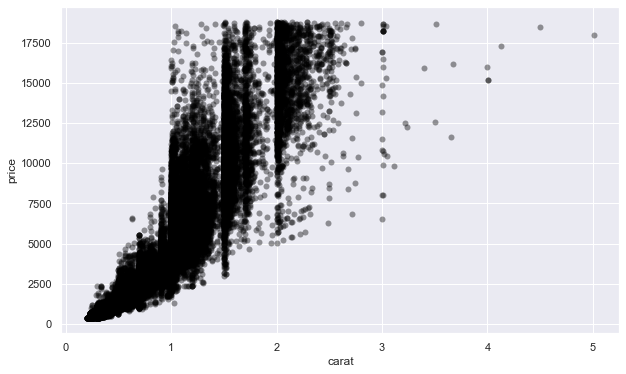

In [11]:
sns.scatterplot(data = diamonds_df, x = 'carat', y = 'price', alpha = 0.4, color = 'black', linewidth=0)

How good does a best guess linear relationship do?

In [12]:
model = LinearRegression(fit_intercept = True)

x = pd.DataFrame(diamonds_df['carat'])
y = pd.DataFrame(diamonds_df['price'])

model.fit(x, y)

b_0 = model.intercept_[0]
b_1 = model.coef_[0][0]

yhat = model.predict(x)


print(f"Intercept: {b_0}")
print(f"Slope: {b_1}")
print(f"R^2: {model.score(x, y)}")
print(f"RMSE {mean_squared_error(y_true=y, y_pred=yhat, squared=False)}")

Intercept: -2256.3605800454457
Slope: 7756.425617968489
R^2: 0.8493305264354858
RMSE 1548.5331930613174


What does the intercept say about extrapolation?

Let's see the best fit line $g(x)$ visually, we'll run our handy dandy plotting by polynomial plot function!

In [13]:
# functions to plot polynomial expressions
from typing import Sequence, Union
import matplotlib.pyplot as plt

Number = Union[int, float, complex]

def polyval(coefficients: Sequence[Number], x: Sequence[Number]) -> np.ndarray:
    # expand dimensions to allow broadcasting (constant time + inexpensive)
    # axis=-1 allows for arbitrarily shaped x
    x = np.expand_dims(x, axis=-1)
    powers = x ** np.arange(len(coefficients))
    return powers @ coefficients

def polyplot(coefficients: Sequence[Number], x: Sequence[Number], color = 'blue') -> None:
    y = polyval(coefficients, x)
    plt.plot(x, y, color = color)

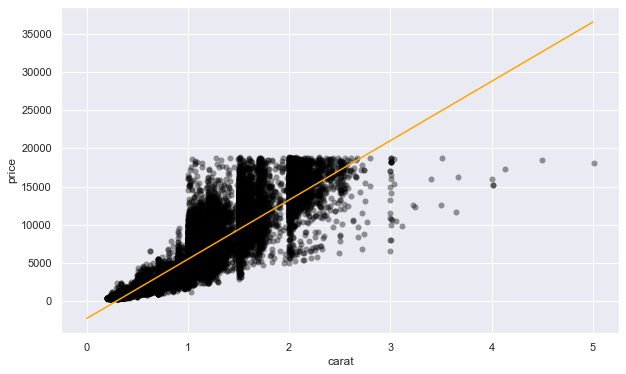

In [14]:
# plotting g(x)
sns.scatterplot(data = diamonds_df, x = 'carat', y = 'price', alpha = 0.4, color = 'black', linewidth=0)
polyplot(np.array([b_0, b_1]), np.linspace(0, 5, 300), color = 'orange')

Maybe the relationship between weight and price is not linear - but exponential? E.g. if the weight of a diamond doubles, maybe the price quadruples? Or linear increases in weight yield percentage increases in price. This seems plausible. 

Besides the plausibility of the functional form, there is an agnostic reason to employ log y as the predictive target. Let's first examine the univariate data!

In [15]:
diamonds_df['price'].describe()

count    53940.000000
mean      3932.799722
std       3989.439738
min        326.000000
25%        950.000000
50%       2401.000000
75%       5324.250000
max      18823.000000
Name: price, dtype: float64

Very large standard error and very long tail which can be seed more clearly here.

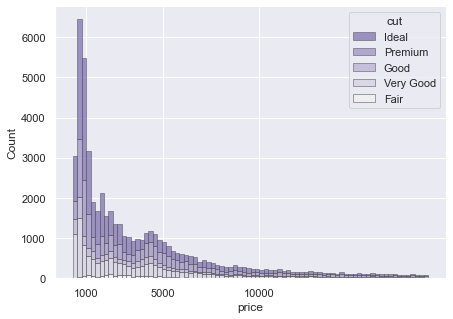

In [16]:
f, ax = plt.subplots(figsize=(7, 5))

sns.despine(f)

sns.histplot(
    diamonds_df,
    x="price", hue="cut",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([1000, 5000, 10000])

Let's take a look at the distribution after logging.

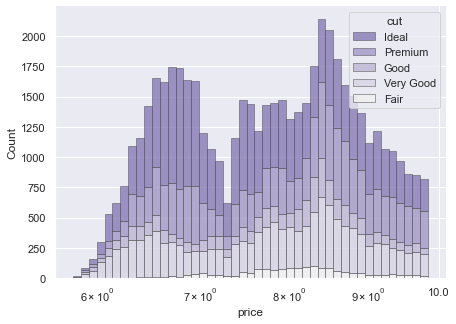

In [17]:
f, ax = plt.subplots(figsize=(7, 5))

sns.despine(f)

sns.histplot(
    diamonds_df,
    x=np.log(diamonds_df['price']), hue="cut",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True, # before this was False
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

Some strange artifacts appear. Why the gap? Why is it "cut" sharply at a maximum? These are questions to ask the one who collected the data. But let's get back to the log story...

Popular wisdom says logging this type of highly skewed-right distribution would possibly make the model "more linear in x". Put another way, it would be easier to "catch" (predict) the long tail since it won't be a long tail anymore after you log-transform. It would also prevent observations with large y's becoming "leverage points" i.e. points that unduly influence the model and thereby warp its ability to predict the average observation. If we have time later in the semester, we can learn about leverage points, but not now. In Econ 382 you learn more reasons for why you should use log the response, but those reasons are relevant for inference so we won't discuss them here.

Let's give the model with $ln(y)$ a whirl. Maybe we'll even learn something about diamonds. The way to create such a model is to simply fit an OLS model to log y. This is called a log-linear model.

In [18]:
model_log = LinearRegression(fit_intercept = True)
 
x = pd.DataFrame(diamonds_df['carat'])
y_log = pd.DataFrame(np.log(diamonds_df['price']))

model_log.fit(x, y_log)

b_0 = model_log.intercept_[0]
b_1 = model_log.coef_[0][0]

yhat = model_log.predict(x)


print(f"Intercept: {b_0}")
print(f"Slope: {b_1}")

Intercept: 6.215020985441328
Slope: 1.9697571124080624


Let's see what this looks like.

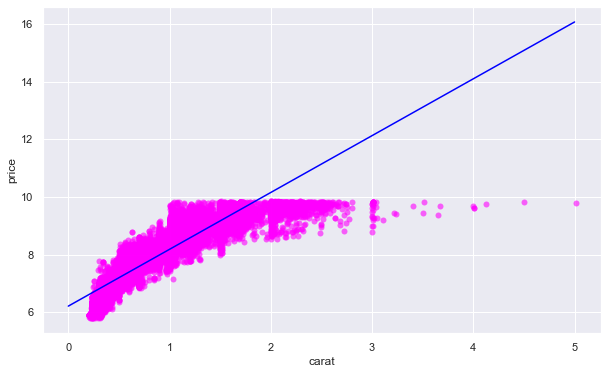

In [19]:
# plotting logistic regression model
sns.scatterplot(data = diamonds_df, x = 'carat', y = np.log(diamonds_df['price']), alpha = 0.6, color = 'magenta', linewidth=0)
polyplot(np.array([b_0, b_1]), np.linspace(0, 5, 300), color = 'blue')

It looks very bad if carat is large. That means our little theory about carats getting larger yielding multiples of price doesn't correspond to reality.

How did we do?

In [20]:
print(f"R^2: {model_log.score(x, y_log)}")
print(f"RMSE {mean_squared_error(y_true=y_log, y_pred=yhat, squared=False)}")

R^2: 0.8467801830517973
RMSE 0.3971635850655834


Look at that RMSE! That dropped like a rock! Is that real?

No. RMSE before is in the units of y. And now y is now in ln($). So this RMSE and the previous RMSE are *not* comparable.

The $R^2$ are *not* comparable either. Even though they're on a [0, 1] scale in both models, the SST's are different so you're measuring the proportion of a different variance.

Let's attempt to compare apples-apples.

In [21]:
# get log_yhat
log_yhat = model_log.predict(pd.DataFrame(diamonds_df['carat']))
yhat = np.exp(log_yhat)

# get residual error
e = [diamonds_df['price'][i] - yhat[i][0] for i in range(len(yhat))]

# Calculating Performance Metrics
SSE = np.sum(pd.Series(e)**2)
SST = np.sum((diamonds_df['price'] - np.mean(diamonds_df['price']))**2)
Rsq = 1 - (SSE / SST)
RMSE = np.sqrt(SSE / (len(diamonds_df) - 2))

print(f"R-sq: {Rsq}")
print(f"RMSE: {RMSE}")

R-sq: -135.5786099312273
RMSE: 46623.75835951125


What does this mean? It means this was a bad idea. Those residuals for large carats are insanely large. They're wrong on a log scale! Which means they're off by orders of magnitude. Working with logged y is dangerous business if you're wrong! Before you were off by a few thousand dollars; now you're off by millions. For example. Let's look at a large diamond:

In [22]:
x_star = pd.DataFrame(diamonds_df[diamonds_df["carat"] > 5]["carat"]) # single value
y_star = pd.DataFrame(diamonds_df[diamonds_df["carat"] > 5]['price'])

print(x_star) # carat
print(y_star) # price

       carat
27415   5.01
       price
27415  18018


In [23]:
# predicted value for linear model
model.predict(x_star)[0][0]

36603.33176597668

In [24]:
# predicted value for log linear model
np.exp(model_log.predict(x_star)[0][0])

9659999.153948447

That's a pretty bad residual!

How about log-log model? 

In [25]:
model_log_log = LinearRegression(fit_intercept = True)
 
x = pd.DataFrame(np.log(diamonds_df['carat']))
y = pd.DataFrame(np.log(diamonds_df['price']))

model_log_log.fit(x, y)

b_0 = model_log_log.intercept_[0]
b_1 = model_log_log.coef_[0][0]

yhat = model_log_log.predict(x)


print(f"Intercept: {b_0}")
print(f"Slope: {b_1}")

Intercept: 8.448660728026857
Slope: 1.6758167307250669


Let's see what it looks like.

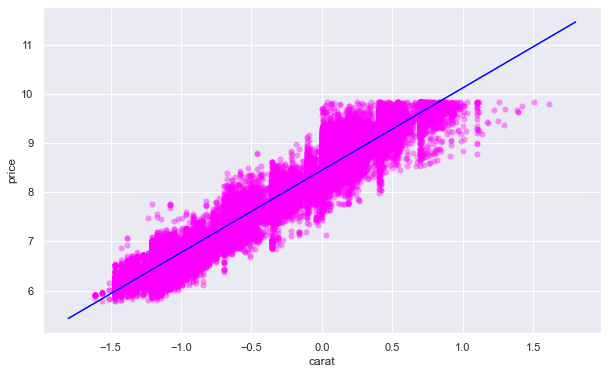

In [26]:
# plotting logistic regression model
sns.scatterplot(data = diamonds_df, x = np.log(diamonds_df['carat']) , y = np.log(diamonds_df['price']),
                alpha = 0.4, color = 'magenta', linewidth=0)
polyplot(np.array([b_0, b_1]), np.linspace(-1.8, 1.8, 300), color = 'blue')

Well look at that! That's a nice looking model. (Note that the slope coefficients in log-log models, i.e. b_1 here, are called "elasticity" in Econ 382 as it measures how the relative change in x affects the relative change in y).

Let's see apples-to-apples to the natural y model.

In [27]:
# get log_log_yhat
log_log_yhat = model_log_log.predict(pd.DataFrame(np.log(diamonds_df['carat'])))
yhat = np.exp(log_log_yhat)

# get residual error
e = [(diamonds_df['price'][i] - yhat[i][0])**2 for i in range(len(yhat))]

# Calculating Performance Metrics
SSE = np.sum(e)
#SST = np.sum((diamonds_df['price'] - np.mean(diamonds_df['price']))**2)
SST = ((diamonds_df['price'] - diamonds_df['price'].mean()) ** 2).sum()
Rsq = 1 - (SSE / SST)
RMSE = np.sqrt(SSE / (len(diamonds_df) - 2))

print(f"R-sq: {Rsq}")
print(f"RMSE: {RMSE}")

R-sq: 0.8280731460390462
RMSE: 1654.1991496321048


This is on-par with the vanilla OLS model, but still doesn't "beat it". There was no guarantee that we would be "beat it" even though we used procedures that are reasonable and popular! My belief is that we really should be wary of the maximum price and employ that in the model. Maybe we'll do this in a lab exercise?

Let's repeat this entire exercise using the length of the diamond. The length of the diamond feature is confusingly named "x" in the dataset. It is an "x" but it's also the diamond's "x"!!!

<AxesSubplot:xlabel='x', ylabel='price'>

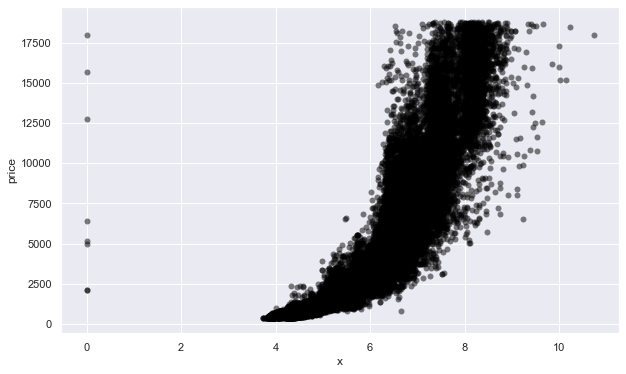

In [28]:
sns.scatterplot(data = diamonds_df, x = 'x', y = 'price', alpha = 0.5, color = 'black', linewidth=0)

Besides the non-linear relationship, what else do you see? Mistakes in the dataset! Can a real diamond have zero length?? Yes. This is the real world. There are mistakes all the time.

Let's kill it! How many are we dealing with here?

In [29]:
len(diamonds_df[diamonds_df['x'] == 0])

8

In [30]:
diamonds_df = diamonds_df[diamonds_df['x'] != 0]

How good does a best guess linear relationship do?

In [31]:
model = LinearRegression(fit_intercept = True)

x = pd.DataFrame(diamonds_df['x'])
y = pd.DataFrame(diamonds_df['price'])

model.fit(x, y)

b_0 = model.intercept_[0]
b_1 = model.coef_[0][0]

yhat = model.predict(x)


print(f"Intercept: {b_0}")
print(f"Slope: {b_1}")
print(f"R^2: {model.score(x, y)}")
print(f"RMSE {mean_squared_error(y_true=y, y_pred=yhat, squared=False)}")

Intercept: -14184.86884744214
Slope: 3160.6737122661975
R^2: 0.7871709136446227
RMSE 1840.1220525337953


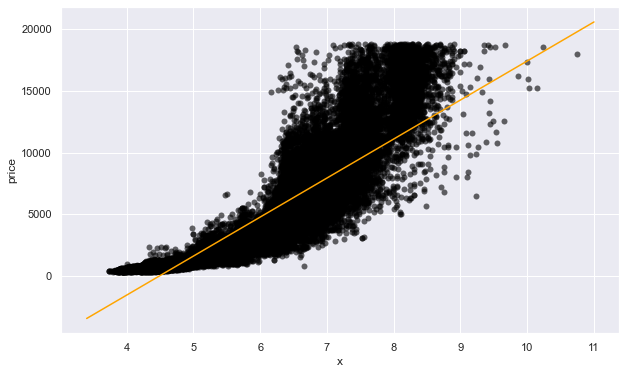

In [32]:
# plotting g(x)
sns.scatterplot(data = diamonds_df, x = 'x', y = 'price', alpha = 0.6, color = 'black', linewidth=0)
polyplot(np.array([b_0, b_1]), np.linspace(3.4, 11, 300), color = 'orange')

Again we got some bad extrapolation going on which we can't fix using a purely linear modeling strategy.

Let's log-linearize it and see how we do.

Intercept: 2.8205241487699038
Slope: 0.8665343048267067


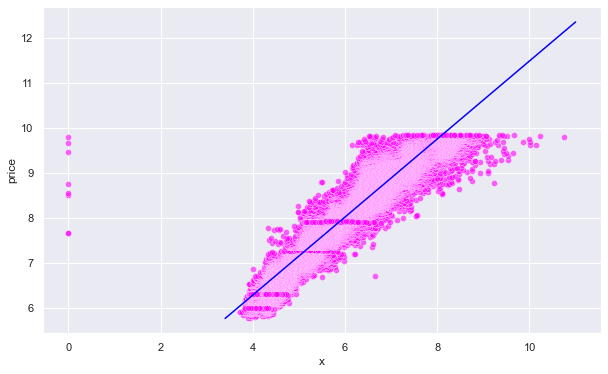

In [33]:
# URL for Diamonds Data
url = "https://vincentarelbundock.github.io/Rdatasets/csv/ggplot2/diamonds.csv"
diamonds_df = pd.read_csv(url)
diamonds_df = diamonds_df.iloc[:, 1:]

model_log = LinearRegression(fit_intercept = True)
 
x = pd.DataFrame(diamonds_df['x'])
y_log = pd.DataFrame(np.log(diamonds_df['price']))

model_log.fit(x, y_log)

b_0 = model_log.intercept_[0]
b_1 = model_log.coef_[0][0]

print(f"Intercept: {b_0}")
print(f"Slope: {b_1}")

# plotting logistic regression model
sns.scatterplot(data = diamonds_df, x = diamonds_df['x'] , y = np.log(diamonds_df['price']), alpha = 0.6, color = 'magenta')
polyplot(np.array([b_0, b_1]), np.linspace(3.4, 11, 300), color = 'blue')

In [34]:
# We have a 0 in the dataset
diamonds_df.iloc[11180:11185]

,carat,cut,color,clarity,depth,table,price,x,y,z
11180,1.08,Premium,F,SI1,62.1,58.0,4953,6.61,6.57,4.09
11181,1.34,Premium,G,SI2,60.1,61.0,4953,7.11,7.06,4.26
11182,1.07,Ideal,F,SI2,61.6,56.0,4954,0.00,6.62,0.00
11183,1.12,Ideal,G,SI2,62.2,55.0,4955,6.68,6.64,4.14
11184,1.07,Ideal,H,SI1,61.1,56.0,4955,6.63,6.60,4.04


In [35]:
# replace the 0 value, what is a good replacement?
diamonds_df['x'].replace(to_replace=0, value = 1, inplace = True)

In [36]:
# check how it looks
diamonds_df.iloc[11180:11185]

,carat,cut,color,clarity,depth,table,price,x,y,z
11180,1.08,Premium,F,SI1,62.1,58.0,4953,6.61,6.57,4.09
11181,1.34,Premium,G,SI2,60.1,61.0,4953,7.11,7.06,4.26
11182,1.07,Ideal,F,SI2,61.6,56.0,4954,1.00,6.62,0.00
11183,1.12,Ideal,G,SI2,62.2,55.0,4955,6.68,6.64,4.14
11184,1.07,Ideal,H,SI1,61.1,56.0,4955,6.63,6.60,4.04


How did we do? Ensure it's apples-apples.

In [37]:
# get log_yhat
log_yhat = model_log.predict(pd.DataFrame(diamonds_df['x']))
yhat = np.exp(log_yhat)

# get residual error
e = [diamonds_df['price'][i] - yhat[i][0] for i in range(len(yhat))]

# Calculating Performance Metrics
SSE = np.sum(pd.Series(e)**2)
SST = np.sum((diamonds_df['price'] - np.mean(diamonds_df['price']))**2)
Rsq = 1 - (SSE / SST)
RMSE = np.sqrt(SSE / (len(diamonds_df) - 2))

print(f"R-sq: {Rsq}")
print(f"RMSE: {RMSE}")

R-sq: 0.5681519334682648
RMSE: 2621.690527327777


Still not better. Log-log?

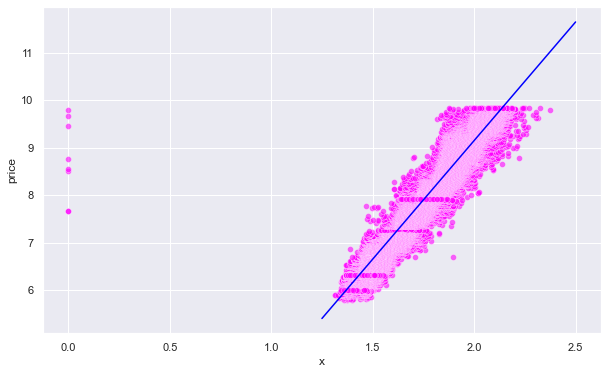

In [38]:
model_log_log = LinearRegression(fit_intercept = True)

x_log = pd.DataFrame(np.log(diamonds_df['x']))
y_log = pd.DataFrame(np.log(diamonds_df['price']))

model_log_log.fit(x_log, y_log)

b_0 = model_log_log.intercept_[0]
b_1 = model_log_log.coef_[0][0]

# plotting logistic regression model
sns.scatterplot(data = diamonds_df, x = np.log(diamonds_df['x']) , y = np.log(diamonds_df['price']), alpha = 0.6, color = 'magenta')
polyplot(np.array([b_0, b_1]), np.linspace(1.25, 2.5, 300), color = 'blue')

How did we do? 

In [39]:
# get log_log_yhat
log_log_yhat = model_log_log.predict(pd.DataFrame(np.log(diamonds_df['x'])))
yhat = np.exp(log_log_yhat)

# get residual error
e = [(diamonds_df['price'][i] - yhat[i][0])**2 for i in range(len(yhat))]

# Calculating Performance Metrics
SSE = np.sum(e)
#SST = np.sum((diamonds_df['price'] - np.mean(diamonds_df['price']))**2)
SST = ((diamonds_df['price'] - diamonds_df['price'].mean()) ** 2).sum()
Rsq = 1 - (SSE / SST)
RMSE = np.sqrt(SSE / (len(diamonds_df) - 2))

print(f"R-sq: {Rsq}")
print(f"RMSE: {RMSE}")

R-sq: 0.830629281148926
RMSE: 1641.8561365816092


We did it. We found a log transformation that seems to give higher predictive power than the vanilla linear model on the raw repsonse and raw feature.

This brings up the whole idea of "model selection". We went hunting for models until we found one that's better. We will hopefully do model selection today...

Transforming y is a big decision as it changes the response metric! The rule of thumb is it is easier to model a response metric that has less extreme values (especially when using linear models) as the extreme values have a big impact on slope coefficients and can distort the best fit line due to the least squares minimization (hence the popularity of logging the response).

Let's see if we get anywhere with this using all the features in this model.

In [40]:
X = pd.get_dummies(X)

In [41]:
# Setting constants
X = pd.get_dummies(diamonds_df.copy())
del X['price']
y = diamonds_df['price']

# Linear model
model_linear = LinearRegression().fit(X, y)
yhat_linear = model_linear.predict(X)

print("Linear Model")
print(f"R^2: {model_linear.score(X, y)}")
print(f"RMSE {mean_squared_error(y_true=y, y_pred=yhat_linear, squared=False)}")

# Log Linear model
model_log = LinearRegression().fit(X, np.log(y))
yhat_log = np.exp(model_log.predict(X))

print("Log Linear Model")
print(f"R^2: {model_log.score(X, np.log(y))}")
print(f"RMSE {mean_squared_error(y_true=y, y_pred=yhat_log, squared=False)}")

Linear Model
R^2: 0.9198917756541412
RMSE 1129.1364734418353
Log Linear Model
R^2: 0.9727590898634567
RMSE 997.5382552564423


This is pretty convincing evidence that this transformation does a better job (at least in our linear modeling context).

## Linear Models with Feature Interactions

Let's go back to modeling price with weight. Let us add a third variable to this plot, color, a metric about the "yellowness" of the diamond. This is an ordinal categorical variable ranging from D (most clear i.e. best) to J (most yellow in this dataset i.e. worst).

We'll be using the `statsmodels` library which supports specifying models using R-style formulas and pandas DataFrames. It is the best way to map interactions between features that I know of.

<AxesSubplot:xlabel='carat', ylabel='price'>

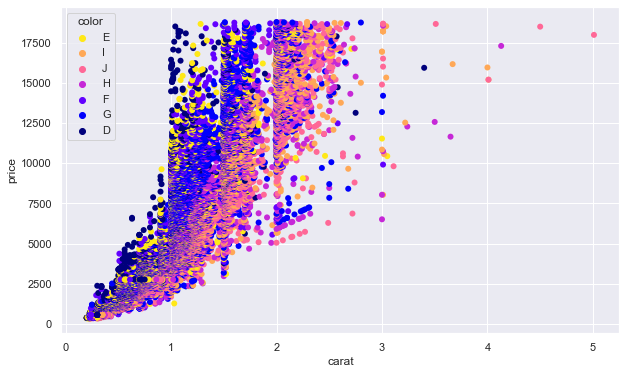

In [42]:
# URL for Diamonds Data
url = "https://vincentarelbundock.github.io/Rdatasets/csv/ggplot2/diamonds.csv"
diamonds_df = pd.read_csv(url)
diamonds_df = diamonds_df.iloc[:, 1:]

# plot price via carat and group by color
sns.scatterplot(data = diamonds_df, x = 'carat', y = 'price', alpha = 1, hue = 'color', linewidth=0, palette='gnuplot2_r')

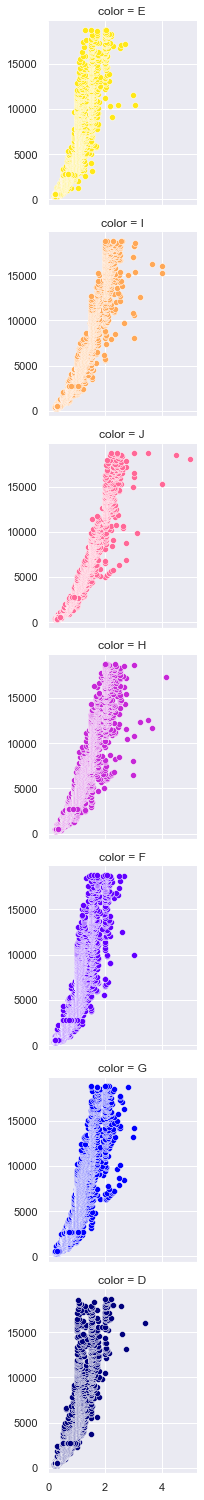

In [43]:
base = sns.FacetGrid(data = diamonds_df, row="color", hue='color', palette='gnuplot2_r')
base.map_dataframe(sns.scatterplot, x="carat",  y = 'price')

What do we see here? It looks like the slope of the price vs. carat linear model is slightly affected by color. For instance, the "D" color diamonds' price increases much faster as weight increases than the "E" color diamonds' price increases in weight, etc. Why do you think this is?

We can picture two of these linear models below by fitting two submodels, one for D and one for J:

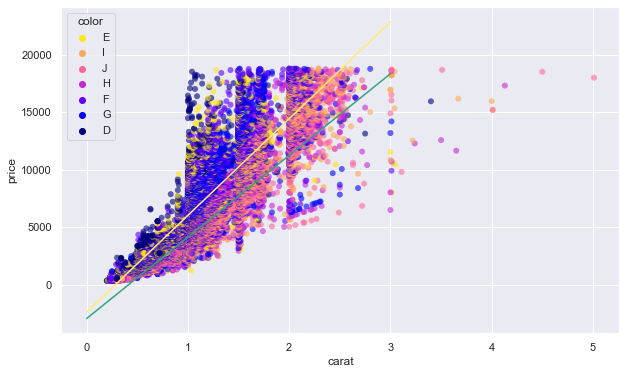

In [44]:
y = diamonds_df['price']

# modeling price by carat for color D
x_D = pd.DataFrame(diamonds_df[diamonds_df['color'] == 'D']['carat'])
y_D = pd.DataFrame(y[diamonds_df['color'] == 'D'])
model_D = LinearRegression(fit_intercept = True).fit(x_D, y_D)
b_D = [model_D.intercept_[0], model_D.coef_[0][0]]

# modeling price by carat for color J
x_J = pd.DataFrame(diamonds_df[diamonds_df['color'] == 'J']['carat'])
y_J = pd.DataFrame(y[diamonds_df['color'] == 'J'])
model_J = LinearRegression(fit_intercept = True).fit(x_J, y_J)
b_J = [model_J.intercept_[0], model_J.coef_[0][0]]

# Lets plot it
sns.scatterplot(data = diamonds_df, x = 'carat', y = 'price', alpha = 0.6, hue = 'color', linewidth=0, palette='gnuplot2_r')
polyplot(np.array(b_D), np.linspace(0, 3, 300), color = '#feeb74') # yellow
polyplot(np.array(b_J), np.linspace(0, 3, 300), color = '#30a47d') # green

This indicates a separate intercept and carat-slope for each color. How is this done? Interacting carat and slope. The formula notation has the `*` operator for this. It is multiplication in formula land after all!

In [45]:
# import statsmodels
import statsmodels.formula.api as smf

# price via color
model_color = smf.ols('price ~ color', data=diamonds_df).fit()

print("Price via Color")
print(model_color.summary())

Price via Color
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     290.2
Date:                Mon, 17 Jan 2022   Prob (F-statistic):               0.00
Time:                        19:58:47   Log-Likelihood:            -5.2292e+05
No. Observations:               53940   AIC:                         1.046e+06
Df Residuals:                   53933   BIC:                         1.046e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3169.9541     47.707    

In [46]:
# price via carat * color
model_cc = smf.ols('price ~ carat * color', data=diamonds_df).fit()

print("\nPrice via Carat * Color")
print(model_cc.summary())


Price via Carat * Color
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                 2.708e+04
Date:                Mon, 17 Jan 2022   Prob (F-statistic):               0.00
Time:                        19:58:47   Log-Likelihood:            -4.6933e+05
No. Observations:               53940   AIC:                         9.387e+05
Df Residuals:                   53926   BIC:                         9.388e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept      

The reference category is color D. This means every other color should start lower and have a lower slope. This is about what we see above.

How much of a better model is this than a straight linear model?

In [47]:
# price via carat + color
model_cc = smf.ols('price ~ carat + color', data=diamonds_df).fit()

print("Price via Carat + Color")
print(model_cc.summary())

Price via Carat + Color
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                 4.893e+04
Date:                Mon, 17 Jan 2022   Prob (F-statistic):               0.00
Time:                        19:58:48   Log-Likelihood:            -4.6998e+05
No. Observations:               53940   AIC:                         9.400e+05
Df Residuals:                   53932   BIC:                         9.400e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2136.2289     20

You can get more predictive accuracy out of this. We added a degree of freedom? Is this gain real? Yes. With one more feature and $n = 54,000$ there is no chance this gain came from overfitting noise. Add 10,000 garbage features, yes, there will be overfitting.

Let's take a look at carat with another variable, depth, a continuous predictor. High depth indicates diamonds are skinny and tall; low depth indicates diamonds are flat like a pancake.

<AxesSubplot:xlabel='carat', ylabel='price'>

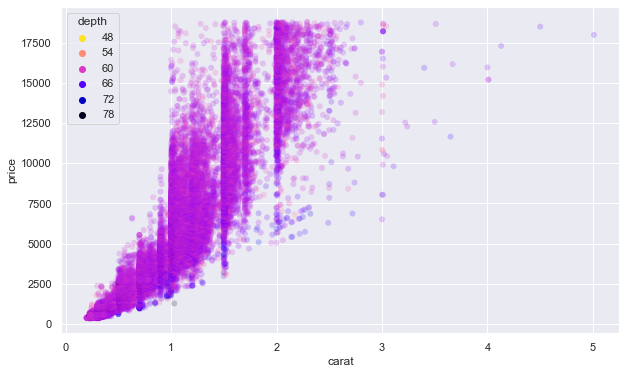

In [48]:
sns.scatterplot(data = diamonds_df, x = 'carat', y = 'price', alpha = 0.2, hue = 'depth', linewidth=0, palette='gnuplot2_r')

It seems people like flatter diamonds and are willing to pay more per carat. Let's see this in the regression:

In [49]:
# price via carat + depth
model_cd = smf.ols('price ~ carat + depth', data=diamonds_df).fit()

print("Price via Carat + Depth")
print(model_cd.summary())

Price via Carat + Depth
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                 1.536e+05
Date:                Mon, 17 Jan 2022   Prob (F-statistic):               0.00
Time:                        19:58:49   Log-Likelihood:            -4.7249e+05
No. Observations:               53940   AIC:                         9.450e+05
Df Residuals:                   53937   BIC:                         9.450e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4045.3332    286

In [50]:
# price via carat * depth
model_cd = smf.ols('price ~ carat * depth', data=diamonds_df).fit()

print("Price via Carat * Depth")
print(model_cd.summary())

Price via Carat * Depth
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                 1.036e+05
Date:                Mon, 17 Jan 2022   Prob (F-statistic):               0.00
Time:                        19:58:49   Log-Likelihood:            -4.7223e+05
No. Observations:               53940   AIC:                         9.445e+05
Df Residuals:                   53936   BIC:                         9.445e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -7823.7383    

If carat increases by one unit, how much does price increase by? A tiny amount of increase.

How about cut?

<AxesSubplot:xlabel='carat', ylabel='price'>

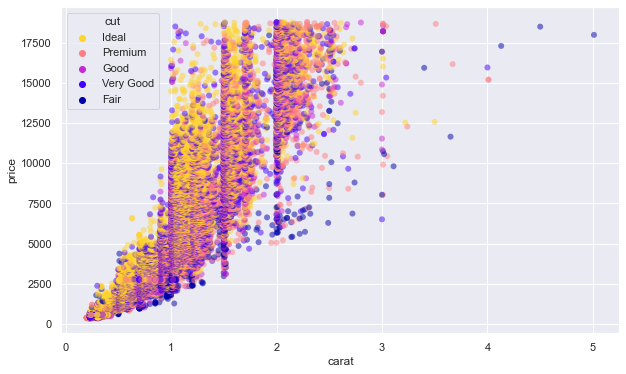

In [51]:
sns.scatterplot(data = diamonds_df, x = 'carat', y = 'price', alpha = 0.5, hue = 'cut', linewidth=0, palette='gnuplot2_r')

In [52]:
# price via carat + cut
model_cc = smf.ols('price ~ carat + cut', data=diamonds_df).fit()

print("Price via Carat + Cut")
print(model_cc.summary())

Price via Carat + Cut
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                 6.437e+04
Date:                Mon, 17 Jan 2022   Prob (F-statistic):               0.00
Time:                        19:58:50   Log-Likelihood:            -4.7142e+05
No. Observations:               53940   AIC:                         9.429e+05
Df Residuals:                   53934   BIC:                         9.429e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -

In [53]:
# price via carat * cut
model_cc = smf.ols('price ~ carat * cut', data=diamonds_df).fit()

print("Price via Carat * Cut")
print(model_cc.summary())

Price via Carat * Cut
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                 3.653e+04
Date:                Mon, 17 Jan 2022   Prob (F-statistic):               0.00
Time:                        19:58:50   Log-Likelihood:            -4.7093e+05
No. Observations:               53940   AIC:                         9.419e+05
Df Residuals:                   53930   BIC:                         9.420e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Interc

Yes.

Can we include all these interactions?

In [54]:
# price via carat + color + depth + cut
model_ccdc = smf.ols('price ~ carat + color + depth + cut', data=diamonds_df).fit()

print("Price via Carat + Color + Depth + Cut")
print(model_ccdc.summary())

Price via Carat + Color + Depth + Cut
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                 3.042e+04
Date:                Mon, 17 Jan 2022   Prob (F-statistic):               0.00
Time:                        19:58:51   Log-Likelihood:            -4.6848e+05
No. Observations:               53940   AIC:                         9.370e+05
Df Residuals:                   53927   BIC:                         9.371e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
In

In [55]:
# price via carat * (color + depth + cut)
model_ccdc = smf.ols('price ~ carat * (color + depth + cut)', data=diamonds_df).fit()

print("Price via Carat * (Color + Depth + Cut)")
print(model_ccdc.summary())

Price via Carat * (Color + Depth + Cut)
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                 1.677e+04
Date:                Mon, 17 Jan 2022   Prob (F-statistic):               0.00
Time:                        19:58:51   Log-Likelihood:            -4.6717e+05
No. Observations:               53940   AIC:                         9.344e+05
Df Residuals:                   53916   BIC:                         9.346e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

A decent gain once again. This may be our best model yet!